In [2]:
import sys
import geoopt
import torch
import numpy as np
import pytest
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

Use `geoopt` to do line search optimization where parameters are constrained to manifolds. 

As example we will try to find the basis of a matrix $A$ in which it has the smallest 1-norm by minimizing $\|XAY\|_1$ where $X,Y$ are orthogonal

In [4]:
sphere = geoopt.manifolds.Sphere()
torus = geoopt.manifolds.ProductManifold(*[(sphere,10)]*2)
point = torus.random(20)
point

Tensor on (Sphere)x(Sphere) manifold containing:
tensor([ 0.1868,  0.7682, -0.0173,  0.2014, -0.2030, -0.1657,  0.1260,  0.2578,
         0.2984,  0.3066, -0.2352, -0.6229,  0.3121,  0.1931, -0.0676,  0.0387,
         0.2800, -0.1483,  0.5337,  0.1752])

100%|██████████| 100/100 [00:01<00:00, 69.79it/s]


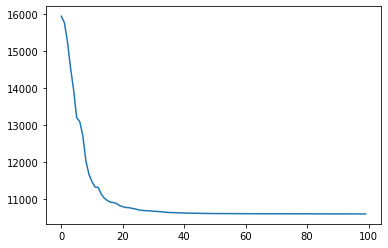

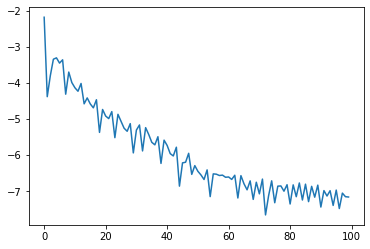

In [9]:
(n,m) = (100,200)
BATCH_SIZE=16
A = torch.randn(n,m)
stiefel = geoopt.manifolds.Stiefel()

X = stiefel.random((n,n))
X.requires_grad=True
Y = stiefel.random((m,m))
Y.requires_grad=True

stief_prod = geoopt.manifolds.ProductManifold((stiefel,(n,n)),(stiefel,(m,m)))
XY = stief_prod.random(n**2+m**2)
XY.requires_grad=True

def closure():
    optim.zero_grad()
    #X,Y = stief_prod.unpack_tensor(XY)
    loss = (X@A@Y).norm(p=1)
    loss.backward()

    return loss.item()

optim = geoopt.optim.RiemannianLineSearch([X,Y])
losses = []
losses2 = []
for i in tqdm(range(100)):
    losses.append(optim.step(closure))


plt.plot(losses)
plt.figure()
log_step_sizes = (np.log10([x if (x is not None) else 1 for x in optim.step_size_history]))
plt.plot(log_step_sizes)
plt.show()

In [8]:
optim.derphi_(0.1)

tensor(-33195566., grad_fn=<AddBackward0>)